# Chapter 20 How to Develop LSTMs for Multi-step Energy Usage Forecasting

In this tutorial, you will discover how to develop long short-term memory recurrent neural networks for multi-step time series forecasting of household power consumption. After completing this tutorial, you will know:
- How to develop and evaluate Univariate and multivariate **Encoder-Decoder LSTMs** for multi-step time series forecasting.
- How to develop and evaluate an CNN-LSTM Encoder-Decoder model for multi-step time series forecasting.
- How to develop and evaluate a ConvLSTM Encoder-Decoder model for multi-step time series forecasting.


## 20.1 Tutorial Overview
This tutorial is divided into nine parts; they are: 
1. Problem Description
2. Load and Prepare Dataset
3. Model Evaluation
4. LSTMs for Multi-step Forecasting
5. Univariate Input and Vector Output

## 20.2 Problem Description

In the interest of brevity, refer to Chapter 17.

## 20.3 Load and Prepare Dataset

In the interest of brevity, refer to Chapter 17 

## 20.4 Model Evaluation

## 20.5 LSTMs for Multi-step Forecasting

In this tutorial, we will explore a suite of LSTM architectures for multi-step time series forecasting. Specifically, we will look at how to develop the following models:
- Vanilla LSTM model with vector output for multi-step forecasting with univariate input data.
- Encoder-Decoder LSTM model for multi-step forecasting with univariate input data.
- Encoder-Decoder LSTM model for multi-step forecasting with multivariate input data.
- CNN-LSTM Encoder-Decoder model for multi-step forecasting with univariate input data.
- ConvLSTM Encoder-Decoder model for multi-step forecasting with univariate input data.


## 20.6 Univariate Input and Vector Output

A good starting point would be to use the prior seven days. An LSTM model expects data to have the shape: **[samples, timesteps, features]**.

lstm: [404.275] 413.4, 401.7, 417.5, 406.5, 406.5, 309.6, 459.7


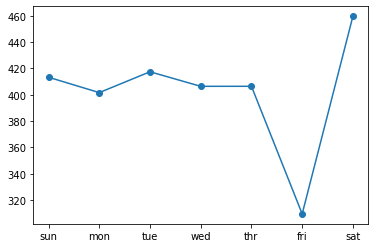

In [1]:
# univariate multi-step lstm for the power usage dataset
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# split a univariate dataset into train/test sets
def split_dataset(data):
    # split into standard weeks
    train, test = data[1:-328], data[-328:-6]
    # restructure into windows of weekly data
    train = array(split(train, len(train)/7))
    test = array(split(test, len(test)/7))
    return train, test

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
        
    # calculate overall RMSE
    s=0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores]) 
    print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end <= len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        # move along one time step
        in_start += 1
    return array(X), array(y)

# train the model
def build_model(train, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 0, 70, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1] 
    # define model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features))) 
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

# make a forecast
def forecast(model, history, n_input):
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))

    # retrieve last observations for input data
    input_x = data[-n_input:, 0]
    # reshape into [1, n_input, 1]
    input_x = input_x.reshape((1, len(input_x), 1))
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

# evaluate a single model
def evaluate_model(train, test, n_input):
    # fit model
    model = build_model(train, n_input)
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # evaluate predictions days for each week
    predictions = array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores

if __name__ == '__main__':
    # load the new file
    dataset = read_csv('household_power_consumption_days.csv', header=0, 
                       infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
    # split into train and test
    train, test = split_dataset(dataset.values)
    # evaluate model and get scores
    n_input = 7
    score, scores = evaluate_model(train, test, n_input)
    # summarize scores
    summarize_scores('lstm', score, scores)
    # plot scores
    days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat'] 
    pyplot.plot(days, scores, marker='o', label='lstm') 
    pyplot.show()

lstm: [392.629] 413.1, 377.9, 338.4, 405.3, 369.0, 334.1, 489.0


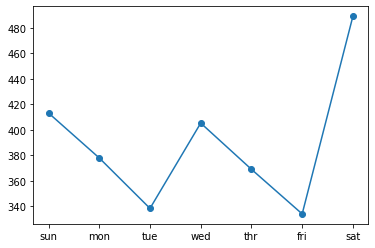

In [2]:
# univariate multi-step lstm for the power usage dataset
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# split a univariate dataset into train/test sets
def split_dataset(data):
    # split into standard weeks
    train, test = data[1:-328], data[-328:-6]
    # restructure into windows of weekly data
    train = array(split(train, len(train)/7))
    test = array(split(test, len(test)/7))
    return train, test

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
        
    # calculate overall RMSE
    s=0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores]) 
    print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end <= len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        # move along one time step
        in_start += 1
    return array(X), array(y)

# train the model
def build_model(train, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 0, 70, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1] 
    # define model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features))) 
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

# make a forecast
def forecast(model, history, n_input):
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))

    # retrieve last observations for input data
    input_x = data[-n_input:, 0]
    # reshape into [1, n_input, 1]
    input_x = input_x.reshape((1, len(input_x), 1))
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

# evaluate a single model
def evaluate_model(train, test, n_input):
    # fit model
    model = build_model(train, n_input)
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # evaluate predictions days for each week
    predictions = array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores

if __name__ == '__main__':
    # load the new file
    dataset = read_csv('household_power_consumption_days.csv', header=0, 
                       infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
    # split into train and test
    train, test = split_dataset(dataset.values)
    # evaluate model and get scores
    n_input = 14
    score, scores = evaluate_model(train, test, n_input)
    # summarize scores
    summarize_scores('lstm', score, scores)
    # plot scores
    days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat'] 
    pyplot.plot(days, scores, marker='o', label='lstm') 
    pyplot.show()

## 20.7 Encoder-Decoder LSTM With Univariate Input

lstm: [402.767] 405.7, 380.1, 340.6, 416.6, 386.1, 328.2, 529.3


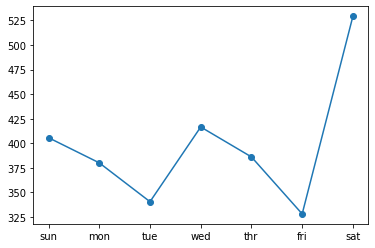

In [4]:
# univariate multi-step encoder-decoder lstm for the power usage dataset
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

# split a univariate dataset into train/test sets
def split_dataset(data):
    # split into standard weeks
    train, test = data[1:-328], data[-328:-6]
    # restructure into windows of weekly data
    train = array(split(train, len(train)/7))
    test = array(split(test, len(test)/7))
    return train, test

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
        
    # calculate overall RMSE
    s=0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores]) 
    print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end <= len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        # move along one time step
        in_start += 1
    return array(X), array(y)

# train the model
def build_model(train, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 0, 20, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1] 
    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    # define model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features))) 
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True)) 
    model.add(TimeDistributed(Dense(100, activation='relu'))) 
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

# make a forecast
def forecast(model, history, n_input):
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))

    # retrieve last observations for input data
    input_x = data[-n_input:, 0]
    # reshape into [1, n_input, 1]
    input_x = input_x.reshape((1, len(input_x), 1))
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

# evaluate a single model
def evaluate_model(train, test, n_input):
    # fit model
    model = build_model(train, n_input)
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # evaluate predictions days for each week
    predictions = array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores

if __name__ == '__main__':
    # load the new file
    dataset = read_csv('household_power_consumption_days.csv', header=0, 
                       infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
    # split into train and test
    train, test = split_dataset(dataset.values)
    # evaluate model and get scores
    n_input = 14
    score, scores = evaluate_model(train, test, n_input)
    # summarize scores
    summarize_scores('lstm', score, scores)
    # plot scores
    days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat'] 
    pyplot.plot(days, scores, marker='o', label='lstm') 
    pyplot.show()

## 20.8 Encoder-Decoder LSTM With Multivariate Input

lstm: [382.425] 371.9, 393.9, 354.3, 379.4, 378.5, 331.5, 455.7


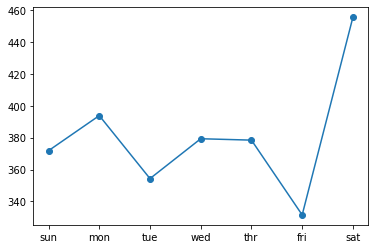

In [6]:
# multivariate multi-step encoder-decoder lstm for the power usage dataset
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

# split a univariate dataset into train/test sets
def split_dataset(data):
    # split into standard weeks
    train, test = data[1:-328], data[-328:-6]
    # restructure into windows of weekly data
    train = array(split(train, len(train)/7))
    test = array(split(test, len(test)/7))
    return train, test

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
        
    # calculate overall RMSE
    s=0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores]) 
    print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end <= len(data):
            X.append(data[in_start:in_end, :])
            y.append(data[in_end:out_end, 0])
        # move along one time step
        in_start += 1
    return array(X), array(y)

# train the model
def build_model(train, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 0, 20, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1] 
    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    # define model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features))) 
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True)) 
    model.add(TimeDistributed(Dense(100, activation='relu'))) 
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

# train the model
def build_model(train, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 0, 50, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1] # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    # define model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features))) 
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True)) 
    model.add(TimeDistributed(Dense(100, activation='relu'))) 
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

# make a forecast
def forecast(model, history, n_input):
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    
    # retrieve last observations for input data
    input_x = data[-n_input:, :]
    # reshape into [1, n_input, n]
    input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat


# evaluate a single model
def evaluate_model(train, test, n_input):
    # fit model
    model = build_model(train, n_input)
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # evaluate predictions days for each week
    predictions = array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores

if __name__ == '__main__':
    # load the new file
    dataset = read_csv('household_power_consumption_days.csv', header=0, 
                       infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
    # split into train and test
    train, test = split_dataset(dataset.values)
    # evaluate model and get scores
    n_input = 14
    score, scores = evaluate_model(train, test, n_input)
    # summarize scores
    summarize_scores('lstm', score, scores)
    # plot scores
    days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat'] 
    pyplot.plot(days, scores, marker='o', label='lstm') 
    pyplot.show()

## 20.9 CNN-LSTM Encoder-Decoder With Univariate Input

lstm: [377.562] 379.0, 393.6, 341.3, 372.3, 371.0, 322.9, 449.7


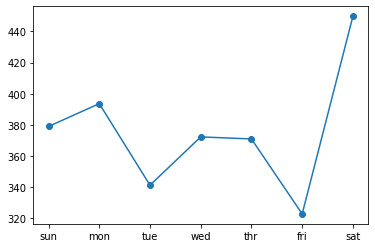

In [7]:
# univariate multi-step encoder-decoder cnn-lstm for the power usage dataset
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

# split a univariate dataset into train/test sets
def split_dataset(data):
    # split into standard weeks
    train, test = data[1:-328], data[-328:-6]
    # restructure into windows of weekly data
    train = array(split(train, len(train)/7))
    test = array(split(test, len(test)/7))
    return train, test

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
        
    # calculate overall RMSE
    s=0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores]) 
    print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end <= len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        # move along one time step
        in_start += 1
    return array(X), array(y)

# train the model
def build_model(train, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 0, 20, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1] # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    # define model
    model = Sequential()
    model.add(Conv1D(64, 3, activation='relu', input_shape=(n_timesteps,n_features))) 
    model.add(Conv1D(64, 3, activation='relu'))
    model.add(MaxPooling1D())
    model.add(Flatten())
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True)) 
    model.add(TimeDistributed(Dense(100, activation='relu'))) 
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

# make a forecast
def forecast(model, history, n_input):
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))

    # retrieve last observations for input data
    input_x = data[-n_input:, 0]
    # reshape into [1, n_input, 1]
    input_x = input_x.reshape((1, len(input_x), 1))
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

# evaluate a single model
def evaluate_model(train, test, n_input):
    # fit model
    model = build_model(train, n_input)
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # evaluate predictions days for each week
    predictions = array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores

if __name__ == '__main__':
    # load the new file
    dataset = read_csv('household_power_consumption_days.csv', header=0, 
                   infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
    # split into train and test
    train, test = split_dataset(dataset.values)
    # evaluate model and get scores
    n_input = 14
    score, scores = evaluate_model(train, test, n_input)
    # summarize scores
    summarize_scores('lstm', score, scores)
    # plot scores
    days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat'] 
    pyplot.plot(days, scores, marker='o', label='lstm') 
    pyplot.show()

## 20.10 ConvLSTM Encoder-Decoder With Univariate Input

lstm: [394.789] 394.7, 433.9, 382.8, 387.9, 375.2, 316.7, 457.0


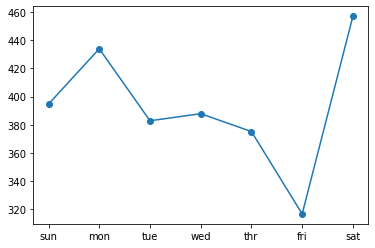

In [11]:
# univariate multi-step encoder-decoder cnn-lstm for the power usage dataset
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D

# split a univariate dataset into train/test sets
def split_dataset(data):
    # split into standard weeks
    train, test = data[1:-328], data[-328:-6]
    # restructure into windows of weekly data
    train = array(split(train, len(train)/7))
    test = array(split(test, len(test)/7))
    return train, test

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
        
    # calculate overall RMSE
    s=0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores]) 
    print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end <= len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        # move along one time step
        in_start += 1
    return array(X), array(y)

# train the model
def build_model(train, n_steps, n_length, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 0, 20, 16
    n_features, n_outputs = train_x.shape[2], train_y.shape[1]
    # reshape into subsequences [samples, timesteps, rows, cols, channels]
    train_x = train_x.reshape((train_x.shape[0], n_steps, 1, n_length, n_features))
    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    # define model
    model = Sequential()
    model.add(ConvLSTM2D(64, (1,3), activation='relu', input_shape=(n_steps, 1, n_length,n_features)))
    model.add(Flatten())
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True)) 
    model.add(TimeDistributed(Dense(100, activation='relu'))) 
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose) 
    return model

# make a forecast
def forecast(model, history, n_steps, n_length, n_input):
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, 0]
    # reshape into [samples, timesteps, rows, cols, channels]
    input_x = input_x.reshape((1, n_steps, 1, n_length, 1))
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

# evaluate a single model
def evaluate_model(train, test, n_steps, n_length, n_input):
    # fit model
    model = build_model(train, n_steps, n_length, n_input)
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast(model, history, n_steps, n_length, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # evaluate predictions days for each week
    predictions = array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores

if __name__ == '__main__':
    # load the new file
    dataset = read_csv('household_power_consumption_days.csv', header=0, 
                   infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
    # split into train and test
    train, test = split_dataset(dataset.values)
    # define the number of subsequences and the length of subsequences
    n_steps, n_length = 2, 7
    # define the total days to use as input
    n_input = n_length * n_steps
    score, scores = evaluate_model(train, test, n_steps, n_length, n_input) # summarize scores
    summarize_scores('lstm', score, scores)
    # plot scores
    days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat'] 
    pyplot.plot(days, scores, marker='o', label='lstm')
    pyplot.show()

## 20.13 Summary
In this tutorial, you discovered how to develop long short-term memory recurrent neural networks for multi-step time series forecasting of household power consumption. Specifically, you learned:
- How to develop and evaluate Univariate and multivariate Encoder-Decoder LSTMs for multi-step time series forecasting.
- How to develop and evaluate an CNN-LSTM Encoder-Decoder model for multi-step time series forecasting.
- How to develop and evaluate a ConvLSTM Encoder-Decoder model for multi-step time series forecasting.